In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB

import joblib

In [2]:
df = pd.read_csv('../data/cleaned_suicide_ideation.csv', keep_default_na=False)

In [3]:
df.head()

,text,text_ready,is_suicidal
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threaten suiciderecently left wife goo...,1
1,Am I weird I don't get affected by compliments...,weird dont get affected compliment come someon...,0
2,Finally 2020 is almost over... So I can never ...,finally almost never hear bad year ever swear ...,0
3,i need helpjust help me im crying so hard,need helpjust help im cry hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",im losthello name adam ive struggle year im af...,1


In [4]:
X = df['text_ready']
y = df['is_suicidal']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

### Baseline Model Selection

#### TF-IDF Vectorizer

In [6]:
tfidf = TfidfVectorizer(
    max_features=50000,   
    ngram_range=(1,2),    
    min_df=3              
)
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

#### Logistic Regression

In [7]:
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"]
}

logreg = LogisticRegression(
    solver="lbfgs",
    max_iter=2000,
    random_state=42
)

grid = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

grid.fit(Xtr, y_train)
best_logreg = grid.best_estimator_
print("Best params:", grid.best_params_)

Best params: {'C': 10, 'penalty': 'l2'}


In [8]:
def evaluate_model(model, Xte, y_test, model_name="Model"):
    proba_te = model.predict_proba(Xte)[:, 1]
    yhat_te  = (proba_te >= 0.5).astype(int)

    print(f"{model_name} Accuracy: {accuracy_score(y_test, yhat_te):.4f}")
    print(f"{model_name} ROC AUC: {roc_auc_score(y_test, proba_te):.4f}")
    print("\nClassification report:\n", classification_report(y_test, yhat_te, digits=3))

    cm = confusion_matrix(y_test, yhat_te)
    sns.heatmap(cm, annot=True, fmt="d", cmap="PiYG", 
                xticklabels=["Pred 0", "Pred 1"], 
                yticklabels=["Actual 0", "Actual 1"])
    plt.title(f"Confusion Matrix — {model_name}")
    plt.show()

Logistic Regression Accuracy: 0.9407
Logistic Regression ROC AUC: 0.9841

Classification report:
               precision    recall  f1-score   support

           0      0.936     0.946     0.941     23287
           1      0.945     0.935     0.940     23128

    accuracy                          0.941     46415
   macro avg      0.941     0.941     0.941     46415
weighted avg      0.941     0.941     0.941     46415



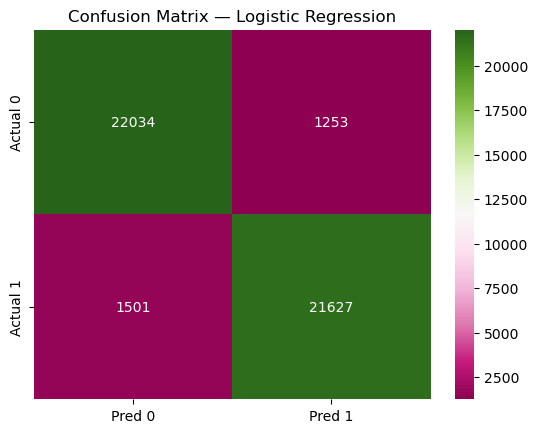

In [9]:
evaluate_model(best_logreg, Xte, y_test, model_name="Logistic Regression")

#### Naive Bayes

In [10]:
nb = MultinomialNB()
nb.fit(Xtr, y_train)

MultinomialNB()

Naive Bayes Accuracy: 0.9179
Naive Bayes ROC AUC: 0.9771

Classification report:
               precision    recall  f1-score   support

           0      0.946     0.887     0.916     23287
           1      0.893     0.949     0.920     23128

    accuracy                          0.918     46415
   macro avg      0.919     0.918     0.918     46415
weighted avg      0.919     0.918     0.918     46415



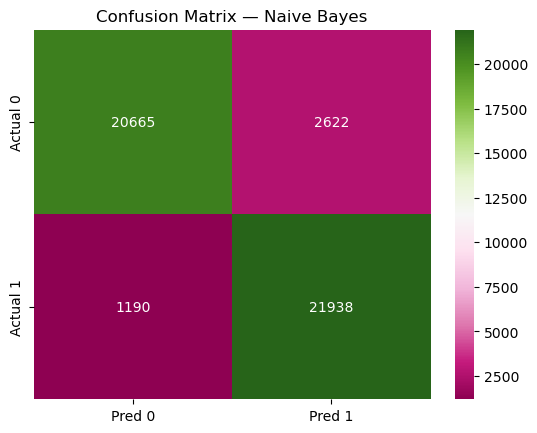

In [11]:
evaluate_model(nb, Xte, y_test, model_name="Naive Bayes")

### Baseline Model Summary

- **Logistic Regression**
  - Accuracy: **0.941**
  - ROC AUC: **0.984**
  - Strong balance of precision and recall across both classes.

- **Naive Bayes**
  - Accuracy: **0.918**
  - ROC AUC: **0.977**
  - Slightly lower precision but higher recall for suicidal class.

**Conclusion:** Logistic Regression performs best overall as a baseline.  
Naive Bayes remains a good alternative when recall is prioritized.

In [12]:
joblib.dump(tfidf, "../models/tfidf_vectorizer.pkl")
joblib.dump(best_logreg, "../models/logreg_baseline.pkl")

['../models/logreg_baseline.pkl']